In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
from ema_workbench import load_results
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy, CategoricalParameter, IntegerParameter,
                           perform_experiments, SequentialEvaluator, Constraint)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.util import ema_logging, utilities
import time
from problem_formulation import get_model_for_problem_formulation
#from signal import signal, SIGPIPE, SIG_DFL
#signal(SIGPIPE, SIG_DFL)
import pickle

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
results = pd.read_csv("results/results_reevaluation.csv")

In [4]:
results.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
results

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,All Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths
0,76,262.700608,10.0,0.640277,141.966071,1.5,0.206812,180.506684,1.0,0.385086,...,1,2,0,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
1,106,306.403307,1.0,0.525580,126.403024,10.0,0.132563,178.796506,1.0,0.513056,...,1,2,1,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
2,97,209.753324,1.5,0.408170,308.826473,10.0,0.314795,270.550638,1.0,0.197602,...,1,2,2,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
3,53,240.358920,10.0,0.939596,49.019791,1.5,0.434024,247.644907,1.0,0.964298,...,1,2,3,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
4,8,305.469762,10.0,0.312076,96.172885,1.0,0.751104,345.582450,1.5,0.304617,...,1,2,4,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,121,177.066954,1.5,0.352684,95.321026,1.5,0.690870,341.099764,10.0,0.258666,...,2,3,995,33,dikesnet,4.912596e+08,0.000000,0.000000e+00,3.725520e+07,0.000000
7996,48,272.273384,1.0,0.375960,47.997302,1.0,0.054370,287.737349,10.0,0.171085,...,2,3,996,33,dikesnet,5.020538e+08,0.001039,0.000000e+00,3.725520e+07,0.000000
7997,70,221.377266,10.0,0.849412,264.339809,1.5,0.612174,180.926475,1.5,0.043990,...,2,3,997,33,dikesnet,4.912596e+08,0.000000,0.000000e+00,3.725520e+07,0.000000
7998,40,155.103737,1.5,0.062811,77.309677,10.0,0.470226,292.422968,1.0,0.254511,...,2,3,998,33,dikesnet,8.670009e+08,0.049281,3.589998e+08,3.725520e+07,0.047613


### Robustness metrics

In this phase we evaluate the robustness of the set of policies. Different robustness metrics capture different aspects and trade-offs of the policies. Moreover, preferences of policy makers might change over time, so it is essential to use various metrics. We have included the following metrics:


Firstly, we define the functions

#### The signal to noise ratio

In [6]:
def s_to_n(data):
    mean = np.mean(data)
    std = np.std(data)
    
    return mean*std

In [7]:
with open('results/results_reevaluation.pickle', 'rb') as f:
     results = pickle.load(f)

In [8]:
experiments, outcomes = results

In [9]:
list_keys = []
for key in outcomes:
    list_keys.append(key)
    

In [10]:
list_keys

['All Costs',
 'Expected Number of Deaths',
 'A.1_Expected Annual Damage',
 'A.1_Dike Investment Costs',
 'A.1_Expected Number of Deaths']

In [11]:
len(outcomes["All Costs"])

8000

In [12]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in list_keys:
        value  = outcomes[outcome][logical]
        sn_ratio = s_to_n(value)
        scores[outcome] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,All Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths
11,1.898724e+17,0.000077,2.951005e+15,0.315096,1.736162e-05
15,1.973243e+17,0.000124,3.212375e+15,0.000000,1.922196e-05
21,1.596221e+17,0.000117,7.812584e+15,0.356495,7.890071e-05
23,1.065574e+17,0.000038,2.737089e+15,0.000000,1.583709e-05
27,4.613675e+17,0.001346,1.838116e+17,0.315096,1.266157e-03
33,3.317308e+17,0.000756,7.104748e+16,0.277573,7.170017e-04
4,3.056283e+16,0.000002,4.604064e+10,0.000000,2.743839e-10
9,1.680349e+17,0.000017,2.737089e+15,0.000000,1.583709e-05


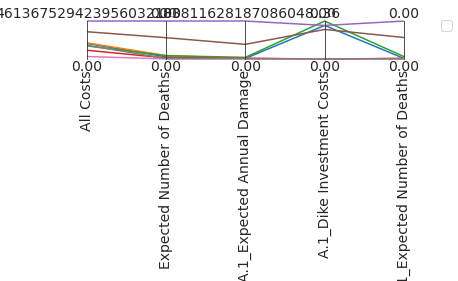

In [13]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, list(data.columns)] = 0
axes = parcoords.ParallelAxes(limits)

axes.plot(data)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,8)

axes.legend()
plt.show()

#f = plt.savefig("visualization/trade-offs.png")

#### Maximum regret
Another robustness metric is maximum regret, calculated again for each policy and for each outcome indicator. Regret is defined for each policy under each scenario. The maximum regret is the maximum of such regret values across all scenarios. We favor policy options with low maximum regret values.

In [14]:
#define function maximum regret 
def calculate_max_regret(data, best):
    return np.abs(best-data)

In [15]:
overall_regret = {}
max_regret = {}
for outcome in outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with outcomes, policies and scenarios
    data = pd.DataFrame({outcome: outcomes[outcome], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)
    
    # we take the difference of the maximum across 
    # the row and the actual values in the row
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    overall_regret[outcome] = outcome_regret
    max_regret[outcome] = outcome_regret.max()

C:\Users\minyr\AppData\Local\Temp\ipykernel_19880\111601588.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\minyr\AppData\Local\Temp\ipykernel_19880\111601588.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\minyr\AppData\Local\Temp\ipykernel_19880\111601588.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\minyr\AppData\Local\Temp\ipykernel_19880\11160

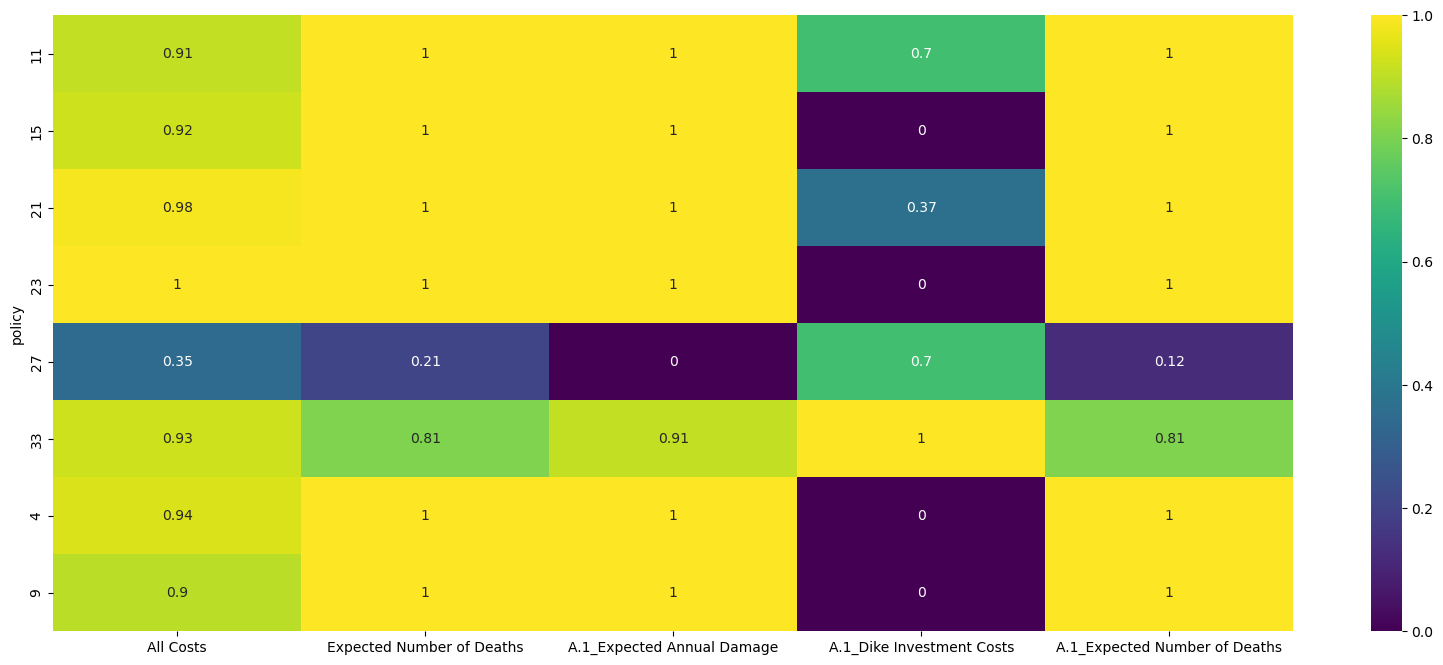

In [16]:
#visualise max_regret in heatmap
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("results/max_regret_heatmap")
plt.show()

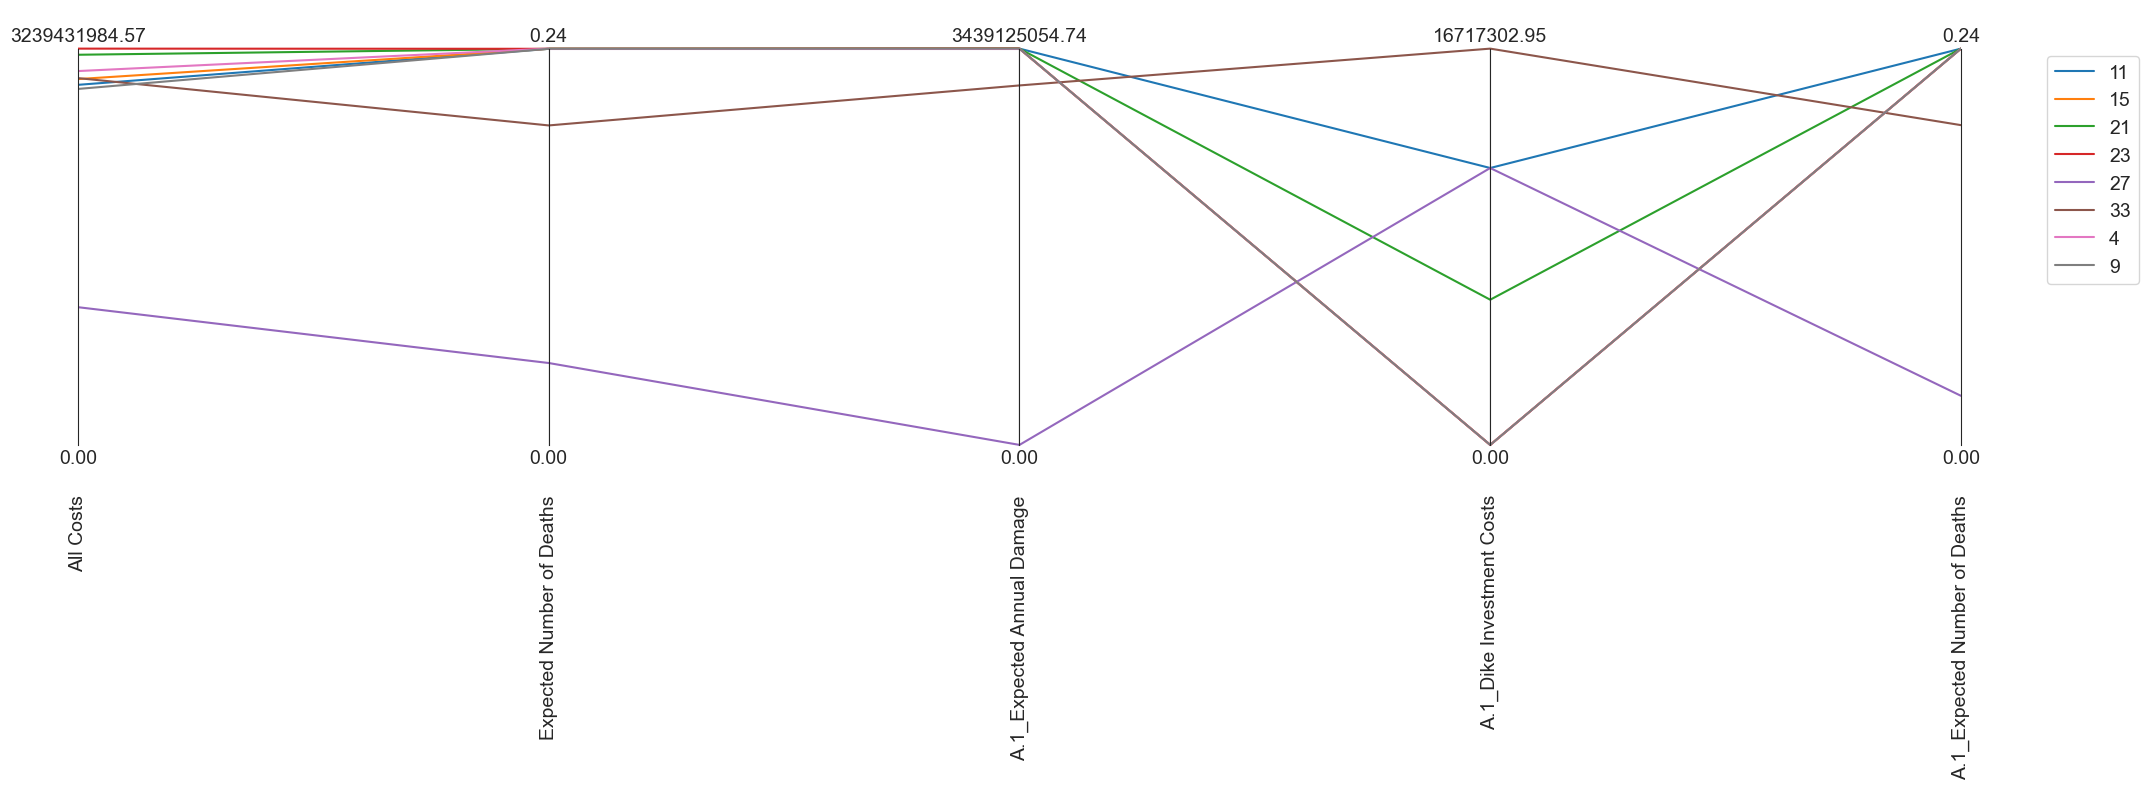

In [17]:
#visuale max_regret in parcoords plot
#to identify policy associated with each line
#legend shows policy numbers
colors = sns.color_palette()

data = max_regret
limits = parcoords.get_limits(data)
limits.loc[0, ['All Costs', 'Expected Number of Deaths', 'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs', 'A.1_Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.savefig("results/max_regret_parcoords")    
plt.show()

In [18]:
# distribution of regret over the set of scenarios.
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

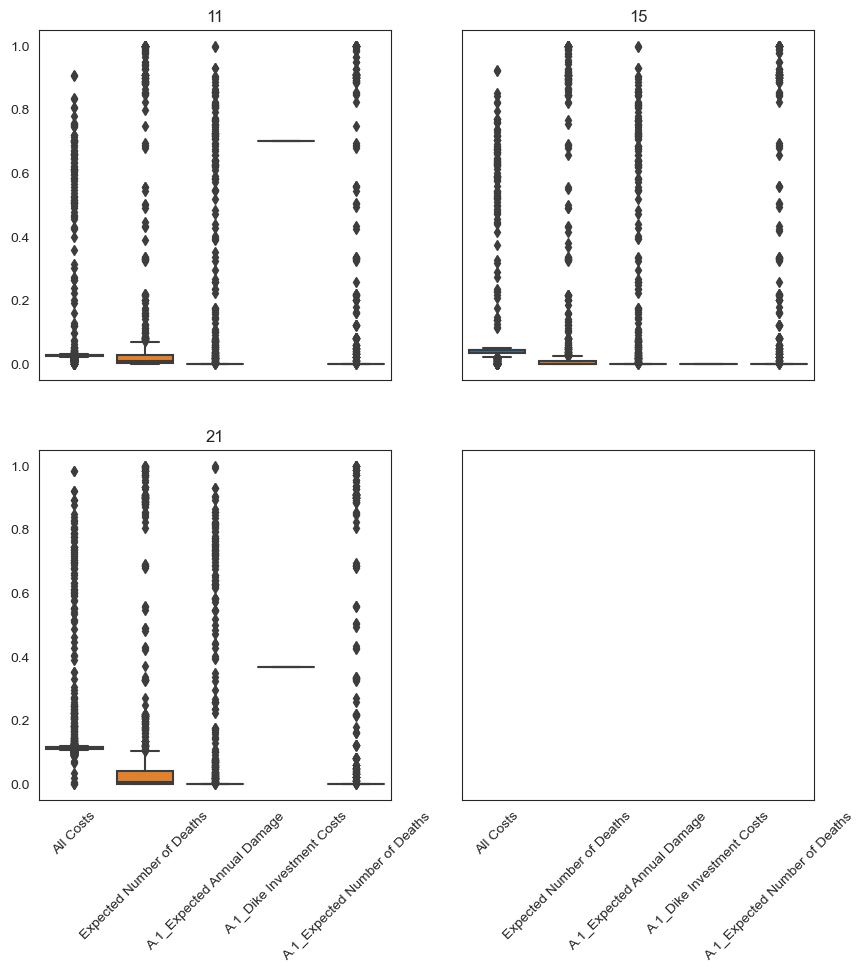

In [19]:
# generating 2 by 2 axes grid, with shared X and Y axis accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)


# to ensure easy iteration turn results into list
axes = [axes[0,0], axes[0,1],
        axes[1,0],]

# zip together the list of axes and the list of key value pairs return by items. 
# iteration returns a tuple of length 2: 1 = ax, 2= the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # dividing by max regret to ensure fair visual comparison. 
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # add title to ensure we know which policy the figure is for
    # rotate x-labels to make visible
    ax.set_title(str(policy))
    ax.tick_params(axis='x', rotation=45)
    plt.xticks(rotation= 45)
    
plt.savefig("results/max_regret_boxplot") 
plt.show()